# MEWpy Optimization


Author: Vitor Pereira

License: [CC BY-SA 4.0](http://creativecommons.org/licenses/by-sa/4.0/)

-------

In this tutorial:

- You will learn how to run combinatorial optimization on microbial communities using MEWpy

## Bacterial cross-feeding via extensive gene loss

Metabolic dependencies between microbial species have a significant impact on the
assembly and activity of microbial communities. However, the evolutionary origins of
such dependencies and the impact of metabolic and genomic architecture on their
emergence are not clear.

Recently, [McNally et al.](https://doi.org/10.1186/s12918-018-0588-4) proposed a method to evolve
cooperative interactions among microbial species by fostering cross-feeding of a
diverse set of metabolites. This was achieved by incrementaly deleting genes on
initially two identical bacterias (E. coli) and increasingly imposing constraints on the
community metabolic network such that two new strains evolve and start to diverge
while maximizing the differences on their genotypes.

The aim is to replicate the experiments using
MEWpy to maximize the number of deleted genes on the two strains
while inducing cross-feeding. 

### Run in Google colab

If you are running this notebook in Colab, you need to perform the following steps, otherwise skip.

In [1]:
%%bash
[[ ! -e /colabtools ]] && exit
! pip install -U -q PyDrive

In [2]:
if 'google.colab' in str(get_ipython()):
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    model_file = drive.CreateFile({'id':'1o0XthuEOs28UJ4XTa9SfFSFofazV-2nN'})
    model_file.GetContentFile('e_coli_core.xml.gz')

## Step 1 - Load the model

In [3]:
from cobra.io import read_sbml_model
import warnings
warnings.filterwarnings('ignore')

model = read_sbml_model('models/ec/e_coli_core.xml.gz')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-11


We will make two copies of the model and rename the two strains

In [4]:
from mewpy import get_simulator
wildtype = get_simulator(model)

In [5]:
ec1 = wildtype.copy()
ec1.id = 'ec1'
ec2 =wildtype.copy()
ec2.id = 'ec2'

In the experiment, we will use the medium defined in the model

In [6]:
from mewpy.simulation import Environment
medium = Environment.from_model(wildtype)
medium

,lb,ub
EX_ac_e,0.0,1000.0
EX_acald_e,0.0,1000.0
EX_akg_e,0.0,1000.0
EX_co2_e,-1000.0,1000.0
EX_etoh_e,0.0,1000.0
EX_for_e,0.0,1000.0
EX_fru_e,0.0,1000.0
EX_fum_e,0.0,1000.0
EX_glc__D_e,-10.0,1000.0
EX_gln__L_e,0.0,1000.0


## Step 2 - Find single strain gene KOs

Two make the search for combinatorial gene deletion on the community model, we will first idenfify combinatorial gene delerions in one strain, and use these results to seed the community gene deletions.

We start by defining a gene deletion optimization problem (`GKOProblem`) defining as objective the maximization of biomass production (f1) and the maximization of the number of deletions.

In [7]:
from mewpy.problems import GKOProblem
from mewpy.optimization.evaluation import TargetFlux, CandidateSize

In [8]:
f1 = TargetFlux(wildtype.biomass_reaction,method='FBA')
f2 = CandidateSize(maximize=True)

To simpilfy the problem, we will define a maximum of 30 gene deletion and run 10 optimization iterations.

In [9]:
problem = GKOProblem(wildtype,
                     [f1,f2],
                     candidate_max_size = 50)


In [10]:
from mewpy.optimization import EA
ea = EA(problem, max_generations=50)
gkos = ea.run(simplify=False)

Building modification target list.


100%|███████████████████████████████████████| 137/137 [00:00<00:00, 2197.73it/s]

Running NSGAII


Eval(s)|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
    100|  0.000000  0.873922  0.000000  0.139131  0.243433|  1.000000  50.000000  27.000000  24.910000  14.832461|
    200|  0.000000  0.873922  0.196462  0.252733  0.255846|  1.000000  50.000000  13.500000  20.180000  16.669361|
    300|  0.000000  0.873922  0.211663  0.353210  0.318573|  1.000000  50.000000  17.000000  21.520000  16.222503|
    400|  0.000000  0.873922  0.374230  0.390360  0.341932|  1.000000  50.000000  21.000000  24.030000  16.826441|
    500|  0.000000  0.873922  0.374230  0.397523  0.340082|  2.000000  50.000000  21.500000  24.690000  16.496481|
    600|  0.000000  0.873922  0.350513  0.331092  0.327334|  3.000000  50.000000  26.000000  28.780000  16.620217|
    700|  0.000000  0.873922  0.000000  0.265574  0.330570|  3.000000  50.000000  47.000000  33.640000  16.697617|
    800|  0.000000  0.873922  0.000000  0.221614  0.316088|  6.000000  50.000000  48

We can have a look to the solution found by the evolutionary algoritm (EA)

In [11]:
ea.dataframe()

,Modification,Size,TargetFlux,Size
0,"{'b3739': 0, 'b2284': 0, 'b2463': 0, 'b3114': ...",50,0.211663,50.0
1,"{'b3739': 0, 'b2284': 0, 'b1524': 0, 'b4232': ...",50,0.211663,50.0
2,"{'b3739': 0, 'b0903': 0, 'b2463': 0, 'b1524': ...",35,0.873922,35.0
3,"{'b3739': 0, 'b0903': 0, 'b4152': 0, 'b2463': ...",34,0.873922,34.0
4,"{'b1380': 0, 'b3739': 0, 'b2284': 0, 'b4152': ...",47,0.211663,47.0
...,...,...,...,...
70,"{'b3739': 0, 'b2284': 0, 'b3114': 0, 'b1524': ...",50,0.200142,50.0
71,"{'b3739': 0, 'b4152': 0, 'b2463': 0, 'b1524': ...",27,0.873922,27.0
72,"{'b1380': 0, 'b3739': 0, 'b2284': 0, 'b2279': ...",50,0.192520,50.0
73,"{'b1380': 0, 'b3739': 0, 'b2284': 0, 'b2279': ...",50,0.192520,50.0


and run an FBA on the first solution (the biomass is set by default as objective)

In [12]:
problem.simulate(solution=gkos[0].values)

objective: 0.21166294973531075
Status: OPTIMAL
Method:FBA

We may now generate solutions that will seed the EA to be used later in the community gene deletions.

In [13]:
import random

init_pop = []
for s in gkos:
    x=s.values
    init_pop.append([k+'_ec1' for k in x.keys()])
    init_pop.append([k+'_ec2' for k in x.keys()])

random.shuffle(init_pop)


## Community mutants 

We can now address our main goal, starting by defining a community model. We will not impose a relative abundance (`merge_biomasses=False`), instead we will include in the optimization task the secondary implicit goal of "minimizing the difference between the mutant growth" using a regularized FBA.  

In [36]:
from mewpy.model import CommunityModel
from mewpy.com import regComFBA

community= CommunityModel([ec1,ec2],merge_biomasses=False,flavor='cobra')
sim = community.get_community_model()
sim.set_environmental_conditions(medium)

Organism: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  8.66it/s]


We will consider 3 optimization objectives:

- Maximize `ec1` growth while ensuring that `ec2` growth is above 0.1/h;
- Maximize `ec2` growth while ensuring that `ec1` growth is above 0.1/h;
- Maximize the total number of gene deletions.

We will be using a Regularized Community FBA (regComFBA) to select a specific solution.

In [27]:
f1 = TargetFlux(community.organisms_biomass['ec1'],
                community.organisms_biomass['ec2'],
                min_biomass_value=0.1,method=regComFBA)

f2 = TargetFlux(community.organisms_biomass['ec2'],
                community.organisms_biomass['ec1'],
                min_biomass_value=0.1,method=regComFBA)

f3 = CandidateSize(maximize=True)

In [28]:
problem = GKOProblem(sim,
                     [f1,f2,f3],
                     candidate_max_size = 60)

Now that we have defined the optimization problem, we may run it (for 10 iterations, and considering a maximum of 60 gene deletions in total)

In [29]:
from mewpy.util.constants import EAConstants
EAConstants.DEBUG = True

ea = EA(problem,
        max_generations=10,
        initial_population=init_pop[:100])

solutions = ea.run(simplify=False)

Building modification target list.


100%|███████████████████████████████████████| 274/274 [00:00<00:00, 1762.72it/s]

Running NSGAII


Eval(s)|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
    100|  0.411442  0.411442  0.411442  0.411442  0.000000|  0.411442  0.411442  0.411442  0.411442  0.000000|  27.000000  50.000000  41.000000  40.320000  7.630046|
    200|  0.000000  0.411442  0.411442  0.402029  0.058629|  0.000000  0.461758  0.411442  0.403716  0.057891|  27.000000  59.000000  44.000000  42.830000  6.959964|
    300|  0.000000  0.612274  0.411442  0.371122  0.125882|  0.000000  0.461758  0.411442  0.367826  0.126195|  27.000000  60.000000  46.000000  44.210000  7.426029|
    400|  0.000000  0.654500  0.411442  0.354860  0.158462|  0.000000  0.617272  0.411442  0.338266  0.152988|  27.000000  60.000000  47.000000  46.560000  7.885835|
    500|  0.000000  0.654500  0.411442  0.355879  0.170375|  0.000000  0.617272  0.411442  0.326564  0.159411|  32.000000  60.000000  48.000000  46.960000  8.522816|
    600|

We may now have a look at the solutions as a dataframe or as a plot

In [30]:
df = ea.dataframe()
df

,Modification,Size,TargetFlux,TargetFlux,Size
0,"{'b0733_ec1': 0, 'b0755_ec2': 0, 'b3739_ec1': ...",52,0.663398,0.131374,52.0
1,"{'b3236_ec2': 0, 'b2282_ec2': 0, 'b3212_ec2': ...",60,0.411442,0.411442,60.0
2,"{'b3236_ec2': 0, 'b2282_ec2': 0, 'b3739_ec1': ...",58,0.612274,0.108767,58.0
3,"{'b2282_ec2': 0, 'b0733_ec1': 0, 'b3212_ec2': ...",49,0.109701,0.691726,49.0
4,"{'b0755_ec2': 0, 'b3739_ec1': 0, 'b2925_ec2': ...",34,0.411442,0.411442,34.0
...,...,...,...,...,...
81,"{'b3236_ec2': 0, 'b2282_ec2': 0, 'b0755_ec2': ...",51,0.617272,0.184155,51.0
82,"{'b3236_ec2': 0, 'b2282_ec2': 0, 'b0733_ec1': ...",58,0.467650,0.287113,58.0
83,"{'b0755_ec2': 0, 'b3739_ec1': 0, 'b2925_ec2': ...",42,0.516813,0.306071,42.0
84,"{'b2282_ec2': 0, 'b3212_ec2': 0, 'b0755_ec2': ...",44,0.516813,0.306070,44.0


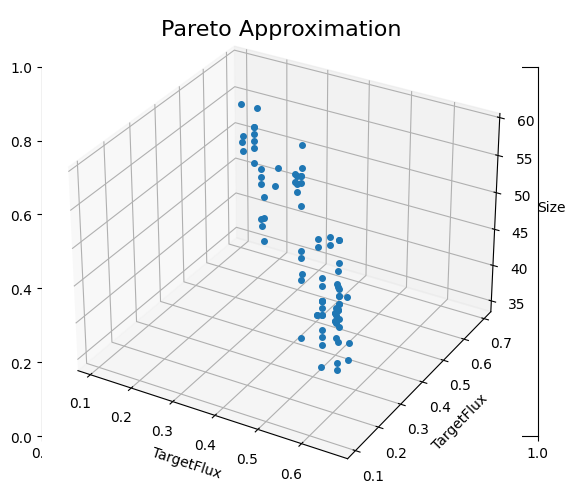

In [31]:
ea.plot()

We may even simulate one of the solution

In [32]:
solution = solutions[5]
solution

[0.293004792691598, 0.46175823055628923, 44.0];{'b0978_ec1': 0, 'b2282_ec1': 0, 'b0755_ec2': 0, 'b2296_ec2': 0, 'b3403_ec2': 0, 'b0723_ec1': 0, 'b0726_ec1': 0, 'b0721_ec2': 0, 'b1612_ec2': 0, 'b1101_ec1': 0, 'b2297_ec2': 0, 'b4122_ec1': 0, 'b4014_ec1': 0, 'b1478_ec1': 0, 'b2463_ec2': 0, 'b3114_ec1': 0, 'b2284_ec1': 0, 'b2579_ec1': 0, 'b3870_ec1': 0, 'b0727_ec1': 0, 'b3870_ec2': 0, 'b2465_ec2': 0, 'b4151_ec1': 0, 'b3739_ec2': 0, 'b3951_ec2': 0, 'b0755_ec1': 0, 'b2283_ec1': 0, 'b0721_ec1': 0, 'b0723_ec2': 0, 'b1854_ec2': 0, 'b0810_ec1': 0, 'b1241_ec2': 0, 'b1817_ec2': 0, 'b0811_ec2': 0, 'b3962_ec2': 0, 'b1479_ec1': 0, 'b1478_ec2': 0, 'b0474_ec1': 0, 'b1819_ec2': 0, 'b1819_ec1': 0, 'b2464_ec2': 0, 'b3114_ec2': 0, 'b1818_ec2': 0, 'b1852_ec2': 0}

In [38]:
problem.simulate(solution=solution.values,method='FBA').find('BIOMASS|growth',show_nulls=True)

,Flux rate
Reaction ID,
BIOMASS_Ecoli_core_w_GAM_ec1,0.151643
BIOMASS_Ecoli_core_w_GAM_ec2,0.610744
community_growth,0.762387


The previous FBA solution is one of many that results from the genes deletion. We can select one particular solution by considering some assumption such as the difference between the organisms growth is minimized while keeping the same community growth: 

In [43]:
problem.simulate(solution=solution.values,method=regComFBA).find('BIOMASS|growth',show_nulls=True)

,Flux rate
Reaction ID,
BIOMASS_Ecoli_core_w_GAM_ec1,0.293005
BIOMASS_Ecoli_core_w_GAM_ec2,0.461758
community_growth,0.754763


We may also relax on the community growth to 90% of confidence by setting `obj_frac=0.9` (by default this value is set to 0.99):

In [44]:
problem.simulate(solution=solution.values,method=regComFBA, obj_frac=0.9).find('BIOMASS|growth',show_nulls=True)

,Flux rate
Reaction ID,
BIOMASS_Ecoli_core_w_GAM_ec1,0.343074
BIOMASS_Ecoli_core_w_GAM_ec2,0.343074
community_growth,0.686148


Other FBA methods can be used such as parsimonious FBA:

In [45]:
problem.simulate(solution=solution.values,method='pFBA').find('BIOMASS|growth',show_nulls=True)

,Flux rate
Reaction ID,
BIOMASS_Ecoli_core_w_GAM_ec1,0.000000
BIOMASS_Ecoli_core_w_GAM_ec2,0.762387
community_growth,0.762387


Me may also have a look to the reactions that were 'deleted'

In [34]:
problem.solution_to_constraints(solution.values)

{'SUCDi_ec2': 0,
 'FRUpts2_ec2': 0,
 'PPCK_ec2': 0,
 'AKGDH_ec1': 0,
 'SUCDi_ec1': 0,
 'ME1_ec1': 0,
 'ADK1_ec1': 0,
 'G6PDH2r_ec2': 0,
 'GLNabc_ec2': 0,
 'FRUpts2_ec1': 0,
 'NADH16_ec1': 0,
 'FRD7_ec1': 0,
 'ME2_ec2': 0,
 'GLNabc_ec1': 0}